In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams["image.origin"] = 'lower'

In [2]:
samples_base_dir = "/eos/home-d/dmapelli/public/latino/Full2017v6s5"
cut              = "boos_sig_mjjincl"
samples_version  = "v8"
model_version    = "v10"

samples_dir = os.path.join(samples_base_dir, cut, "samples", samples_version)

model_dir   = os.path.join(samples_base_dir, cut, "models",  model_version)
import os 
os.makedirs(model_dir, exist_ok=True)


In [3]:
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

## Samples preparation for NN

In [4]:
## using 
## source /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/setup.sh
#!pip3 install --user imbalanced-learn==0.5

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras import backend as K
from keras.callbacks import *

Using TensorFlow backend.


#### v8
'mjj_vbs', 'vbs_0_pt', 'vbs_1_pt', 'vbs_0_eta', 'vbs_1_eta', 'deltaeta_vbs', 'deltaphi_vbs', 
'mjj_vjet', 'vjet_0_pt', 'vjet_1_pt', 'vjet_0_eta', 'vjet_1_eta', 'Lepton_pt', 'Lepton_eta', 
'Lepton_flavour', 'PuppiMET', 'nJets', 'N_jets_central', 'N_jets_forward', 'Zvjets_0', 
'Zlep', 'Asym_vbs', 'Asym_vjet', 'A_ww', 'Mw_lep_reco', 'Mtw_lep', 'w_lep_pt', 'Mww', 'R_ww', 'R_mw', 'Centr_vbs', 'Centr_ww

#### v9

'mjj_vbs', 'vbs_0_pt', 'vbs_1_pt', 'vbs_0_eta', 'vbs_1_eta', 'deltaeta_vbs', 'deltaphi_vbs', 'mjj_vjet', 'vjet_0_pt', 'vjet_1_pt', 'vjet_0_eta', 'vjet_1_eta', 'Lepton_pt', 'Lepton_eta', 'Lepton_flavour', 'PuppiMET', 'Zvjets_0', 'Zlep', 'Asym_vbs', 'Asym_vjet', 'A_ww', 'Mtw_lep', 'w_lep_pt', 'Mww', 'R_ww', 'R_mw', 'Centr_vbs', 'Centr_ww'

In [73]:
import yaml
yaml_vars = yaml.safe_load(open(os.path.join(model_dir, "variables.yml")))
print("yaml: ", type(yaml_vars), len(yaml_vars))
cols = yaml_vars

yaml:  <class 'list'> 28


In [7]:
X_sig = signal[cols].values
X_bkg = bkg[cols].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values

In [8]:
X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(f"{model_dir}/scaler_model.pkl", "wb"))

vjet_0_eta


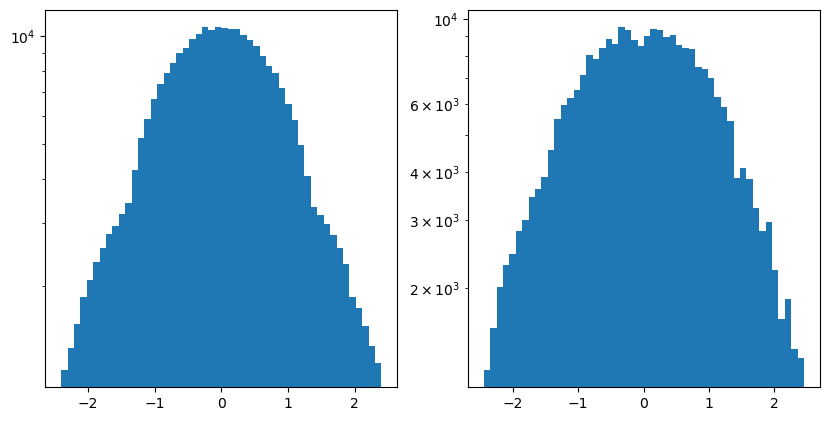

In [10]:
i = 10
print(cols[i])
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5), dpi=100)
ax1.hist(X[:,i], bins=50)
ax1.set_yscale("log")
ax2.hist(X_scaled[:,i], weights=W, bins=50)
plt.yscale("log")

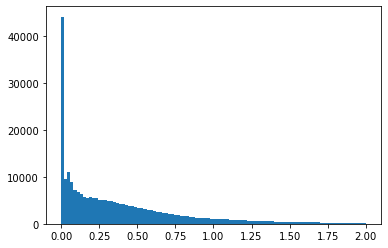

In [11]:
_ = plt.hist(W, bins=100, range=(0,2))

##  Balancing
Let's give 25% to validation (validation during training + test). 
The validation is then split in 50%-50% for training validation and final result

In [74]:
X_train, X_temp, y_train, y_temp, W_train, W_temp = train_test_split(X_scaled, Y,      W,      test_size=0.1)
X_val,   X_test, y_val,   y_test, W_val,   W_test = train_test_split(X_temp,   y_temp, W_temp, test_size=0.7)

In [85]:
print("Training   dataset: ", X_train.shape)
print("Testing    dataset: ", X_test.shape)
print("Validation dataset: ", X_val.shape)

Training   dataset:  (252034, 28)
Testing    dataset:  (19603, 28)
Validation dataset:  (8401, 28)


Create generators to balance signal and background

In [99]:
training_generator,   steps_per_epoch_train = balanced_batch_generator(X_train, y_train, W_train, batch_size=1024, sampler=RandomOverSampler())
validation_generator, steps_per_epoch_val   = balanced_batch_generator(X_val,   y_val,   W_val,   batch_size=1024, sampler=RandomOverSampler())

## Keras model

In [100]:
# import numpy as np
# from matplotlib import pyplot as plt
from IPython.display import clear_output

from sklearn.metrics import roc_auc_score, roc_curve

## callbacks
# updatable plot
# a minimal example (sort of)

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.auc = []
        self.dnn_score_plot = []
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        #training_loss = model.predict_generator(training_generator, steps=1000)
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss')) #training_loss[0])
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc')) #training_loss[1])
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,8))
        clear_output(wait=True)

        # ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, "o-", label="loss")
        ax1.plot(self.x, self.val_losses, "o-", label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, "o-", label="accuracy")
        ax2.plot(self.x, self.val_acc, "o-", label="validation accuracy")
        ax2.legend()
        
        pred = model.predict(X_test, batch_size=2048)
        auc_w = roc_auc_score(y_test,pred, sample_weight=W_test)
        self.auc.append(auc_w)
        #fpW, tpW, thW = roc_curve(y_test, pred, sample_weight=W_test)
        #ax3.plot(fpW, tpW, label=f"ROC W (AUC={auc_w:.3f})", color="red")
        #ax3.legend(loc=(0.4, 0.5), fontsize="large")
        ax3.plot(self.x, self.auc, "o-")

        h1 = ax4.hist(pred[y_test==0],weights=W_test[y_test==0], bins=40,density=True, label="false", histtype="step")
        h2 = ax4.hist(pred[y_test==1],weights=W_test[y_test==1], bins=40, density=True, label="true", histtype="step")
        ax4.legend()        
        
        self.dnn_score_plot.append((h1,h2))
        
        plt.show();
        
plot_losses = PlotLosses()

In [101]:
model = Sequential()
model.add(Dense(80, input_dim=X_train.shape[1], activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(30, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 80)                2320      
_________________________________________________________________
dropout_13 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 50)                4050      
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 30)                1530      
_________________________________________________________________
dropout_15 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 31        
Total para

In [102]:
## callbacks

# auto_save = ModelCheckpoint("../models/model12_balanced_100_50.hd5", monitor='val_loss', 
#                     verbose=1, save_best_only=True, save_weights_only=False, 
#                     mode='auto', period=5)
#
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
#                             patience=10, verbose=1)

In [103]:
## In case you do not want to use the generators

# history = model.fit(
#             X_train,y_train, 
#             sample_weight=W_train, 
#             epochs=50,
#             validation_data = (X_val, y_val, W_val),
#             batch_size=1024,
#             shuffle=True 
#             )

In [104]:
history = model.fit_generator(
            training_generator, 
            epochs=50,
            #initial_epoch=200,
            steps_per_epoch=steps_per_epoch_train, 
            validation_data = validation_generator, 
            validation_steps = steps_per_epoch_val,
            #callbacks=[plot_losses],
            callbacks = [], 
            )

Epoch 1/50
448/448 [==============================] - 3s 7ms/step - loss: 0.5739 - acc: 0.5925 - val_loss: 0.5308 - val_acc: 0.5982
Epoch 2/50
448/448 [==============================] - 2s 5ms/step - loss: 0.5494 - acc: 0.6115 - val_loss: 0.5219 - val_acc: 0.6092
Epoch 3/50
448/448 [==============================] - 2s 5ms/step - loss: 0.5429 - acc: 0.6188 - val_loss: 0.5198 - val_acc: 0.6124
Epoch 4/50
448/448 [==============================] - 2s 5ms/step - loss: 0.5378 - acc: 0.6250 - val_loss: 0.5191 - val_acc: 0.6113
Epoch 5/50
448/448 [==============================] - 2s 5ms/step - loss: 0.5350 - acc: 0.6271 - val_loss: 0.5187 - val_acc: 0.6121
Epoch 6/50
448/448 [==============================] - 2s 5ms/step - loss: 0.5336 - acc: 0.6284 - val_loss: 0.5173 - val_acc: 0.6145
Epoch 7/50
448/448 [==============================] - 2s 5ms/step - loss: 0.5311 - acc: 0.6300 - val_loss: 0.5148 - val_acc: 0.6137
Epoch 8/50
448/448 [==============================] - 2s 5ms/step - loss: 0.

In [105]:
n = 30
plt.hist(plot_losses.dnn_score_plot[n][0][1][:-1], bins=plot_losses.dnn_score_plot[n][0][1], weights=plot_losses.dnn_score_plot[n][0][0], histtype="step")
plt.hist(plot_losses.dnn_score_plot[n][1][1][:-1], bins=plot_losses.dnn_score_plot[n][1][1], weights=plot_losses.dnn_score_plot[n][1][0], histtype="step")

AttributeError: 'PlotLosses' object has no attribute 'dnn_score_plot'

In [111]:
model.save(f"{model_dir}/model.h5")

>>> Computing AUC...


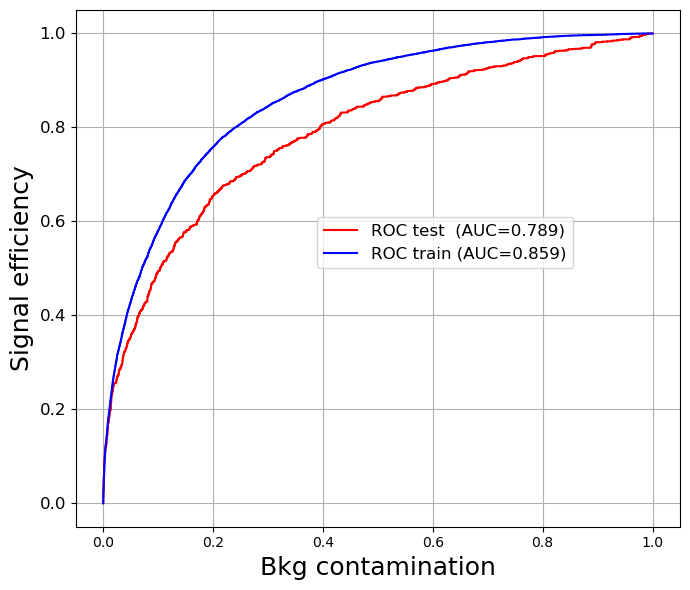

In [106]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve

pred_test  = model.predict(X_test,  batch_size=2048)
pred_train = model.predict(X_train, batch_size=2048)
auc_w_test  = roc_auc_score(y_test, pred_test,  sample_weight=W_test)
auc_w_train = roc_auc_score(y_train,pred_train, sample_weight=W_train)
fpW_test,  tpW_test,  thW_test  = roc_curve(y_test,  pred_test , sample_weight=W_test)
fpW_train, tpW_train, thW_train = roc_curve(y_train, pred_train, sample_weight=W_train)
#print("AUC score: " + str(auc))

fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

# ax1.plot(fp, tp, label=f"ROC (AUC={auc:.3f})", color="blue")
ax1.plot(fpW_test,  tpW_test,  label=f"ROC test  (AUC={auc_w_test:.3f})", color="red")
ax1.plot(fpW_train, tpW_train, label=f"ROC train (AUC={auc_w_train:.3f})", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18)

#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large")

ax1.grid()

ax1.legend(loc=(0.4, 0.5), fontsize="large")

fig.tight_layout()

In [107]:
#r = model.evaluate_generator(training_generator, steps=1000)
#r = model.evaluate_generator(validation_generator, steps=1000)


In [108]:
#print(model.metrics_names, r)

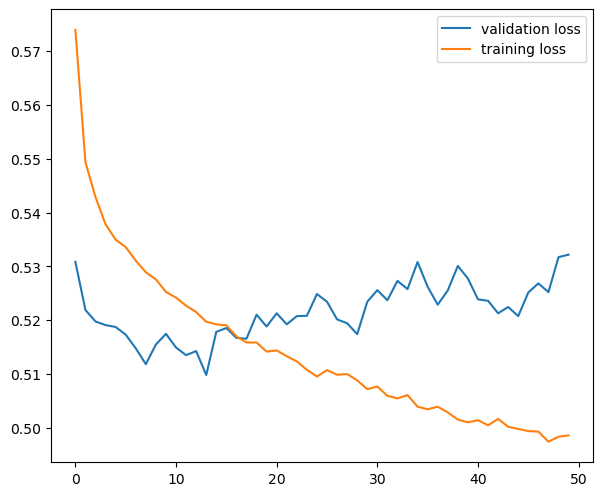

In [109]:
fig, ax = plt.subplots(figsize=(7,6), dpi=100)
ax.plot(history.epoch, history.history["val_loss"], label="validation loss")
ax.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

Ks_2sampResult(statistic=0.05555648480868425, pvalue=9.592003820461245e-05)

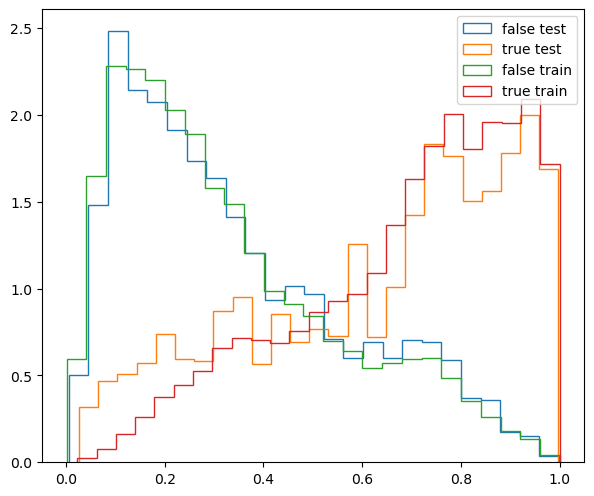

In [110]:
results_test  = model.predict(X_test, batch_size=2048)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(results_test[y_test==0],weights=W_test[y_test==0], bins=25, density=True, label="false test", histtype="step")
plt.hist(results_test[y_test==1],weights=W_test[y_test==1], bins=25, density=True, label="true test", histtype="step")
results_train = model.predict(X_train, batch_size=2048)
plt.hist(results_train[y_train==0],weights=W_train[y_train==0], bins=25, density=True, label="false train", histtype="step")
plt.hist(results_train[y_train==1],weights=W_train[y_train==1], bins=25, density=True, label="true train", histtype="step")
#plt.yscale("log")
plt.legend()

# 
# 

#results_train[y_train==1]
rtest  = [x[0] for x in results_test[y_test==1]]
rtrain = [x[0] for x in results_train[y_train==1]]

from scipy import stats
stats.ks_2samp(rtrain, rtest)

In [56]:
results_test[y_test==1].shape

(8624, 1)

## Evaluation by sample

In [57]:
bkg["y"] = model.predict(scaler.transform(bkg[cols].values), batch_size=2048)

In [58]:
signal["y"] = model.predict(scaler.transform(signal[cols].values), batch_size=2048)

In [59]:
wjets = bkg[bkg["sample_name"] == "Wjets"]
top = bkg[bkg["sample_name"] == "top"]
dy = bkg[bkg["sample_name"] == "DY"]

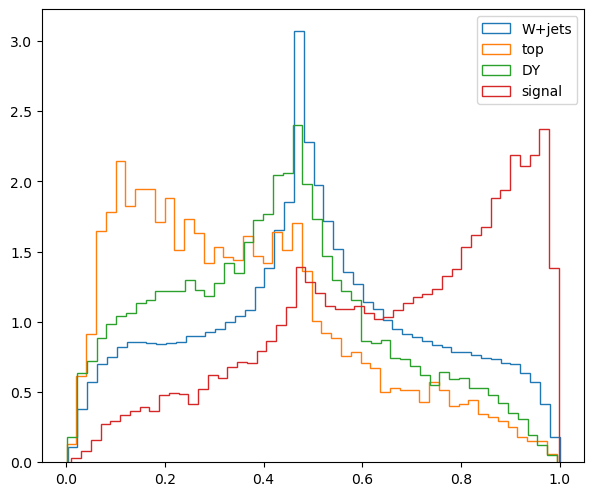

In [60]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(bkg[bkg["sample_name"] == "Wjets"]["y"], bins=50, density=True, label="W+jets", histtype="step")
plt.hist(bkg[bkg["sample_name"] == "top"]["y"],   bins=50, density=True, label="top",    histtype="step")
plt.hist(bkg[bkg["sample_name"] == "DY"]["y"],    bins=50, density=True, label="DY",     histtype="step")

plt.hist(signal["y"], bins=50,density=True, label="signal", histtype="step")
#plt.yscale("log")
plt.legend()

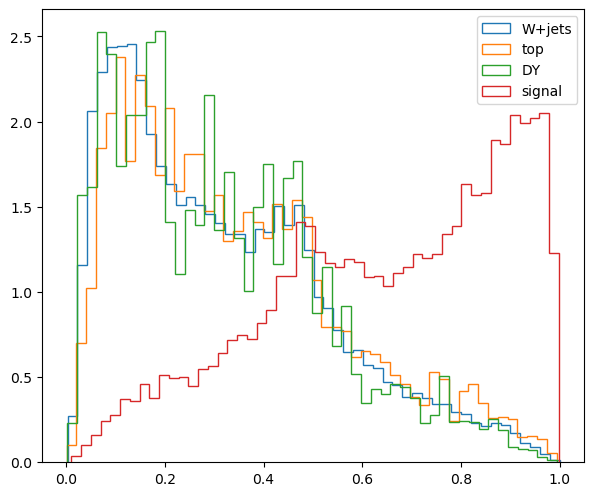

In [112]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(wjets["y"], weights=wjets.weight_norm, bins=50, density=True, label="W+jets", histtype="step")
plt.hist(top["y"],   weights=top.weight_norm,  bins=50, density=True, label="top",    histtype="step")
plt.hist(dy["y"],    weights=dy.weight_norm,  bins=50, density=True, label="DY",     histtype="step")

plt.hist(signal["y"], weights=signal.weight_norm, bins=50,density=True, label="signal", histtype="step")
#plt.yscale("log")
plt.legend()